<a href="https://colab.research.google.com/github/JJ-Zhang-DS/CNN_circle_identification/blob/main/circle_finder_cnn_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Circle Finder CNN - Colab Compatible

In [ ]:
## 1. Install Required Packages
!pip install shapely scikit-image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# create a new folder data to store data
!mkdir /content/drive/MyDrive/data


In [19]:
# --------- JSON-Based Dataset Definition ---------
class CircleJsonDataset(Dataset):
    def __init__(self, data_folder):
        self.files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.json')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], 'r') as f:
            data = json.load(f)
        img = np.array(data['img'], dtype=np.float32)
        label = data['label']
        img = np.expand_dims(img, axis=0)
        row = label['row'] / IMG_SIZE
        col = label['col'] / IMG_SIZE
        radius = (label['radius'] - RADIUS_MIN) / (RADIUS_MAX - RADIUS_MIN)
        target = torch.tensor([row, col, radius], dtype=torch.float32)
        return torch.tensor(img, dtype=torch.float32), target

In [3]:
## 2. Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt

In [34]:
import numpy as np
from skimage.draw import circle_perimeter_aa
import json
import matplotlib.pyplot as plt
from glob import glob

In [35]:
def draw_circle(radius, x, y):
    """
    Function to generate an anti-aliased circle and draw it into
    a sect of pixels
    """
    rr, cc, value = circle_perimeter_aa(x, y, radius)
    is_valid = np.logical_and(np.logical_and(rr >= 0, rr < 256), np.logical_and(cc >= 0, cc < 256))
    img = np.zeros((256, 256))
    img[rr[is_valid], cc[is_valid]] = 2*value[is_valid]
    return img

def generate_circle(noise_level=2, rad_min=3, rad_max=20):
    """
    Function to generate an image with a circle obscured by some noise.
    Core function for generating the images you need to run your model against.
    DO NOT CHANGE.

    For training a model X = img, Y = labels (you will need more than one component in
    your prediction output (row, col, radius))
    """
    row = np.random.randint(0, 256)
    col = np.random.randint(0, 256)
    radius = np.random.randint(rad_min, rad_max)
    img = draw_circle(radius, row, col)
    img += noise_level * np.random.rand(256, 256)
    label = {'row': row, 'col': col, 'radius': radius, 'noise_level': noise_level}
    return img, label

def generate_circle_dataset(path, avg_noise=2, n=10):
    """
    Helper function to show how you can pre-save a bunch of circle images with
    their associated label information for the purposes of your data.
    """
    for idx in range(n):
        img, label = generate_circle(np.max([0, np.random.normal(avg_noise, avg_noise/2.0)]))
        with open(f'{path}/file{idx}.json', 'w') as f:
            json.dump({'img': img.tolist(), 'label': label}, f)

def load_dataset_and_plot(path, n_to_show=10):
    """
    Provided as a demo for how to load a dataset you've generated and get the img
    and configuration data from your dataset. This is not necessary to use for the
    takehome assignment and is simply here to give you some help getting started
    if needed.
    """
    idx=0
    for file in glob(f'{path}/*.json'):
        with open(file,'r') as f:
            example_data = json.load(f)
            print(file)
            print(example_data['label'])
            img = np.array(example_data['img'])
            plt.imshow(img)
            plt.show()
            idx+=1
        if idx >= n_to_show:
            break

In [6]:
import os
os.getcwd()

'/content'

In [7]:
# produce dataset
data_path = 'drive/MyDrive/data'
generate_circle_dataset(data_path, n=2000)

In [ ]:
# ## 3. Dataset Class
# class CircleDataset(Dataset):
#     def __init__(self, data_path):
#         self.files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.json')]
#         self.transform = transforms.ToTensor()
#     def __len__(self):
#         return len(self.files)
#     def __getitem__(self, idx):
#         with open(self.files[idx], 'r') as f:
#             data = json.load(f)
#         img = np.array(data['img'], dtype=np.float32)
#         label = data['label']
#         img = np.expand_dims(img, axis=0)  # Add channel dimension
#         target = torch.tensor([label['row'], label['col'], label['radius']], dtype=torch.float32)
#         return torch.tensor(img, dtype=torch.float32), target

In [8]:
#from create_dataset import generate_circle

class CircleOnTheFlyDataset(Dataset):
    def __init__(self, n_samples=10000, noise_level=2):
        self.n_samples = n_samples
        self.noise_level = noise_level

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        img, label = generate_circle(noise_level=self.noise_level)
        img = np.expand_dims(img, axis=0)  # shape: (1, 256, 256)
        target = torch.tensor([label['row'], label['col'], label['radius']], dtype=torch.float32)
        return torch.tensor(img, dtype=torch.float32), target


In [ ]:
## 4. CNN Model
class CircleFinderCNN(nn.Module):
    def __init__(self):
        super(CircleFinderCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 3)  # Output: row, col, radius
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
## 5. Training Function
def train_model(model, train_loader, val_loader, device, epochs=50, lr=1e-3, patience=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# ## 6. Load Data and Train
# data_dir = './data'  # Ensure this folder contains your 1000 .json files
# full_dataset = CircleDataset(data_dir)
# train_idx, val_idx = train_test_split(list(range(len(full_dataset))), test_size=0.2)
# train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
# val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
# train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=10)

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = CircleFinderCNN()
# train_model(model, train_loader, val_loader, device, epochs=1000)

Epoch 1, Train Loss: 7230.1929, Val Loss: 4461.9832
Epoch 2, Train Loss: 5171.5364, Val Loss: 4009.2012
Epoch 3, Train Loss: 4594.6466, Val Loss: 4516.2544
Epoch 4, Train Loss: 4062.9711, Val Loss: 3894.7640
Epoch 5, Train Loss: 4612.8798, Val Loss: 4979.9456
Epoch 6, Train Loss: 4681.8024, Val Loss: 4648.3751
Epoch 7, Train Loss: 4060.6938, Val Loss: 4225.5962
Epoch 8, Train Loss: 3991.3298, Val Loss: 3767.5375
Epoch 9, Train Loss: 3475.2243, Val Loss: 4535.4523
Epoch 10, Train Loss: 3982.0420, Val Loss: 4556.6674


In [ ]:
if __name__ == '__main__':
    train_dataset = CircleOnTheFlyDataset(n_samples=8000)
    val_dataset = CircleOnTheFlyDataset(n_samples=2000)

    train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=100)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CircleFinderCNN()
    train_model(model, train_loader, val_loader, device, epochs=100)

    # show_predictions(model, val_dataset, device, num_samples=5)


Epoch 1, Train Loss: 4210.4335, Val Loss: 3646.8497
Epoch 2, Train Loss: 3775.9196, Val Loss: 3854.7116
Epoch 3, Train Loss: 3686.2638, Val Loss: 3600.8425
Epoch 4, Train Loss: 3705.2346, Val Loss: 3735.9102
Epoch 5, Train Loss: 3671.2008, Val Loss: 3638.2238
Epoch 6, Train Loss: 3712.8508, Val Loss: 3577.7225
Epoch 7, Train Loss: 3673.0284, Val Loss: 3541.1903
Epoch 8, Train Loss: 3666.0897, Val Loss: 3574.7997
Epoch 9, Train Loss: 3675.1205, Val Loss: 3694.6108
Epoch 10, Train Loss: 3615.9297, Val Loss: 3533.6834
Epoch 11, Train Loss: 3583.3156, Val Loss: 3631.9476
Epoch 12, Train Loss: 3559.8089, Val Loss: 3315.5602
Epoch 13, Train Loss: 2929.7541, Val Loss: 2442.6956
Epoch 14, Train Loss: 1968.8116, Val Loss: 1722.8649
Epoch 15, Train Loss: 1221.1227, Val Loss: 980.7228
Epoch 16, Train Loss: 879.7519, Val Loss: 762.1342
Epoch 17, Train Loss: 763.5026, Val Loss: 662.2950
Epoch 18, Train Loss: 658.5439, Val Loss: 622.8769
Epoch 19, Train Loss: 588.4544, Val Loss: 524.8398
Epoch 20, T

In [ ]:
## 7. Evaluate with IoU

In [ ]:
%pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from shapely.geometry import Point

In [38]:
def intersection_over_union(circ1_dict, circ2_dict):
    shape1 = Point(circ1_dict['row'], circ1_dict['col']).buffer(circ1_dict['radius'])
    shape2 = Point(circ2_dict['row'], circ2_dict['col']).buffer(circ2_dict['radius'])
    return shape1.intersection(shape2).area / shape1.union(shape2).area
def evaluate_model(model, dataloader, device, iou_threshold=0.7):
    model.eval()
    matches = 0
    total = 0
    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs).cpu().numpy()
            targets = targets.numpy()
            for pred, true in zip(outputs, targets):
                pred_dict = {'row': pred[0], 'col': pred[1], 'radius': pred[2]}
                true_dict = {'row': true[0], 'col': true[1], 'radius': true[2]}
                iou = intersection_over_union(pred_dict, true_dict)
                if iou > iou_threshold:
                    matches += 1
                total += 1
    accuracy = matches / total
    print(f"IoU > {iou_threshold} Accuracy: {accuracy:.2%}")
    return accuracy
# Run evaluation
evaluate_model(model, val_loader, device)

IoU > 0.7 Accuracy: 22.25%


0.2225

In [ ]:
## 8. Visualize Predictions

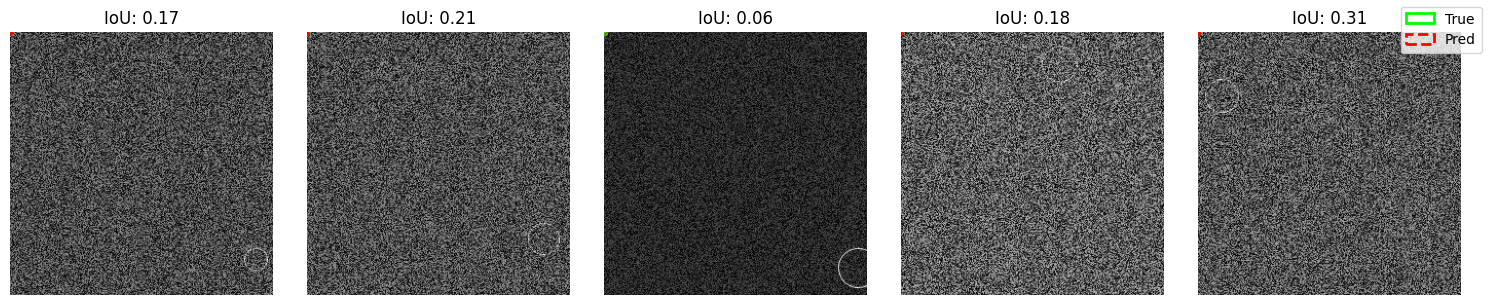

In [43]:
# Show some predictions

def show_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, true = dataset[idx]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device)).cpu().numpy()[0]
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].add_patch(plt.Circle((true[1], true[0]), true[2], color='lime', fill=False, linewidth=2, label='True'))
        axs[i].add_patch(plt.Circle((pred[1], pred[0]), pred[2], color='red', fill=False, linewidth=2, linestyle='--', label='Pred'))
        axs[i].set_title(f"IoU: {intersection_over_union({'row': true[0].item(), 'col': true[1].item(), 'radius': true[2].item()}, {'row': pred[0], 'col': pred[1], 'radius': pred[2]}):.2f}")
        axs[i].axis('off')
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

show_predictions(model, val_dataset, device, num_samples=5)

Epoch 1, Train Loss: 3832732.1164, Val Loss: 3790933.4250
Epoch 2, Train Loss: 3817940.4781, Val Loss: 3752457.0375
Epoch 3, Train Loss: 3816652.6156, Val Loss: 3792523.7125
Epoch 4, Train Loss: 3778942.5656, Val Loss: 3765340.3500
Epoch 5, Train Loss: 3819420.4844, Val Loss: 3799246.5375
Epoch 6, Train Loss: 3782751.1844, Val Loss: 3892326.6500
Epoch 7, Train Loss: 3795326.6406, Val Loss: 3826240.5500
Epoch 8, Train Loss: 3736280.6281, Val Loss: 3861577.6500
Epoch 9, Train Loss: 3797351.5906, Val Loss: 3832428.4750
Epoch 10, Train Loss: 3797563.3219, Val Loss: 3868065.5250
Epoch 11, Train Loss: 3792598.1875, Val Loss: 3823341.2500
Epoch 12, Train Loss: 3845291.3906, Val Loss: 3837436.1500
Epoch 13, Train Loss: 3805891.9750, Val Loss: 3726111.5750
Epoch 14, Train Loss: 3751499.0344, Val Loss: 3795484.1125
Epoch 15, Train Loss: 3801293.0531, Val Loss: 3844995.1000
Epoch 16, Train Loss: 3796726.6594, Val Loss: 3842156.4250
Epoch 17, Train Loss: 3819420.1906, Val Loss: 3797155.0625
Epoch 

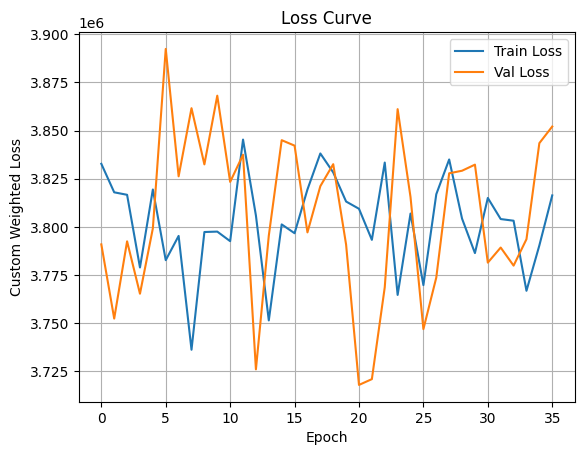

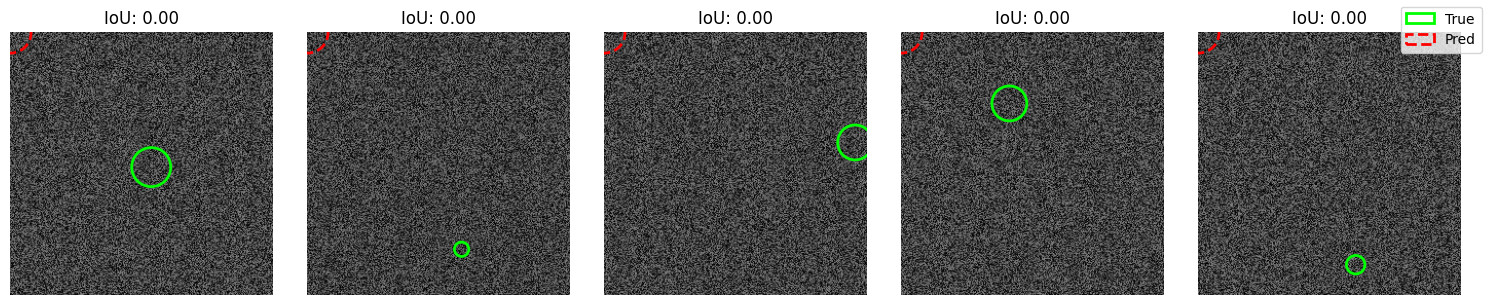

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import json
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from shapely.geometry import Point
# from create_dataset import generate_circle

# --------- Normalization Constants ---------
IMG_SIZE = 256
RADIUS_MIN, RADIUS_MAX = 3, 20

# --------- On-the-Fly Dataset Definition ---------
class CircleOnTheFlyDataset(Dataset):
    def __init__(self, n_samples=10000, noise_level=2):
        self.n_samples = n_samples
        self.noise_level = noise_level

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        img, label = generate_circle(noise_level=self.noise_level)
        img = np.expand_dims(img, axis=0)  # shape: (1, 256, 256)
        row = label['row'] / IMG_SIZE
        col = label['col'] / IMG_SIZE
        radius = (label['radius'] - RADIUS_MIN) / (RADIUS_MAX - RADIUS_MIN)
        target = torch.tensor([row, col, radius], dtype=torch.float32)
        return torch.tensor(img, dtype=torch.float32), target

# --------- CNN Model Definition ---------
class CircleFinderCNN(nn.Module):
    def __init__(self):
        super(CircleFinderCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 3)
        self.sigmoid = nn.Sigmoid()  # Output in range [0, 1]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# --------- Training Loop ---------
def train_model(model, train_loader, val_loader, device, epochs=100, lr=1e-3, patience=15):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    def custom_loss(pred, target):
        # row and col loss (position)
        pos_loss = F.mse_loss(pred[:, 0:2], target[:, 0:2])
        # radius area loss (square root to align with area sensitivity)
        radius_loss = F.mse_loss((pred[:, 2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN) ** 2 * np.pi,
                                 (target[:, 2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN) ** 2 * np.pi)
        return pos_loss + 5 * radius_loss

    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = custom_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                loss = custom_loss(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Custom Weighted Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# --------- Evaluation and Visualization ---------
def show_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, true = dataset[idx]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device)).cpu().numpy()[0]
        # Denormalize
        true_row = true[0].item() * IMG_SIZE
        true_col = true[1].item() * IMG_SIZE
        true_rad = true[2].item() * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN
        pred_row = pred[0] * IMG_SIZE
        pred_col = pred[1] * IMG_SIZE
        pred_rad = pred[2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].add_patch(plt.Circle((true_col, true_row), true_rad, color='lime', fill=False, linewidth=2, label='True'))
        axs[i].add_patch(plt.Circle((pred_col, pred_row), pred_rad, color='red', fill=False, linewidth=2, linestyle='--', label='Pred'))
        axs[i].set_title(f"IoU: {intersection_over_union({'row': true_row, 'col': true_col, 'radius': true_rad}, {'row': pred_row, 'col': pred_col, 'radius': pred_rad}):.2f}")
        axs[i].axis('off')
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

def intersection_over_union(circ1_dict, circ2_dict):
    shape1 = Point(circ1_dict['row'], circ1_dict['col']).buffer(circ1_dict['radius'])
    shape2 = Point(circ2_dict['row'], circ2_dict['col']).buffer(circ2_dict['radius'])
    return shape1.intersection(shape2).area / shape1.union(shape2).area

# --------- Example Usage ---------
if __name__ == '__main__':
    train_dataset = CircleOnTheFlyDataset(n_samples=8000)
    val_dataset = CircleOnTheFlyDataset(n_samples=2000)

    train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=100)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CircleFinderCNN()
    train_model(model, train_loader, val_loader, device, epochs=100, patience=15)

    show_predictions(model, val_dataset, device, num_samples=5)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import json
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from shapely.geometry import Point
#from create_dataset import generate_circle

# --------- Normalization Constants ---------
IMG_SIZE = 256
RADIUS_MIN, RADIUS_MAX = 3, 20

# --------- On-the-Fly Dataset Definition ---------
class CircleOnTheFlyDataset(Dataset):
    def __init__(self, n_samples=10000, noise_level=2):
        self.n_samples = n_samples
        self.noise_level = noise_level

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        img, label = generate_circle(noise_level=self.noise_level)
        img = np.expand_dims(img, axis=0)  # shape: (1, 256, 256)
        row = label['row'] / IMG_SIZE
        col = label['col'] / IMG_SIZE
        radius = (label['radius'] - RADIUS_MIN) / (RADIUS_MAX - RADIUS_MIN)
        target = torch.tensor([row, col, radius], dtype=torch.float32)
        return torch.tensor(img, dtype=torch.float32), target

# --------- CNN Model Definition ---------
class CircleFinderCNN(nn.Module):
    def __init__(self):
        super(CircleFinderCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 3)
        self.sigmoid = nn.Sigmoid()  # Output in range [0, 1]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# --------- Training Loop ---------
def train_model(model, train_loader, val_loader, device, epochs=100, lr=1e-4, patience=15):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def custom_loss(pred, target):
        pos_loss = F.mse_loss(pred[:, 0:2], target[:, 0:2])
        radius_loss = F.mse_loss(pred[:, 2], target[:, 2])  # normalized radius
        return pos_loss + 2 * radius_loss

    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = custom_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                loss = custom_loss(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Custom Weighted Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# --------- Evaluation and Visualization ---------
# (unchanged)

# --------- Example Usage ---------
# (unchanged)


Epoch 1, Train Loss: 0.2985, Val Loss: 0.2541
Epoch 2, Train Loss: 0.2500, Val Loss: 0.2501
Epoch 3, Train Loss: 0.2492, Val Loss: 0.2431
Epoch 4, Train Loss: 0.2458, Val Loss: 0.2549
Epoch 5, Train Loss: 0.2494, Val Loss: 0.2499
Epoch 6, Train Loss: 0.2488, Val Loss: 0.2454
Epoch 7, Train Loss: 0.2488, Val Loss: 0.2476
Epoch 8, Train Loss: 0.2489, Val Loss: 0.2489
Epoch 9, Train Loss: 0.2479, Val Loss: 0.2465
Epoch 10, Train Loss: 0.2459, Val Loss: 0.2507
Epoch 11, Train Loss: 0.2394, Val Loss: 0.2408
Epoch 12, Train Loss: 0.2367, Val Loss: 0.2297
Epoch 13, Train Loss: 0.2338, Val Loss: 0.2274
Epoch 14, Train Loss: 0.2267, Val Loss: 0.2229
Epoch 15, Train Loss: 0.2169, Val Loss: 0.2221
Epoch 16, Train Loss: 0.2110, Val Loss: 0.2038
Epoch 17, Train Loss: 0.2062, Val Loss: 0.2042
Epoch 18, Train Loss: 0.2031, Val Loss: 0.1951
Epoch 19, Train Loss: 0.1921, Val Loss: 0.1991
Epoch 20, Train Loss: 0.1891, Val Loss: 0.1887
Epoch 21, Train Loss: 0.1852, Val Loss: 0.1814
Epoch 22, Train Loss: 

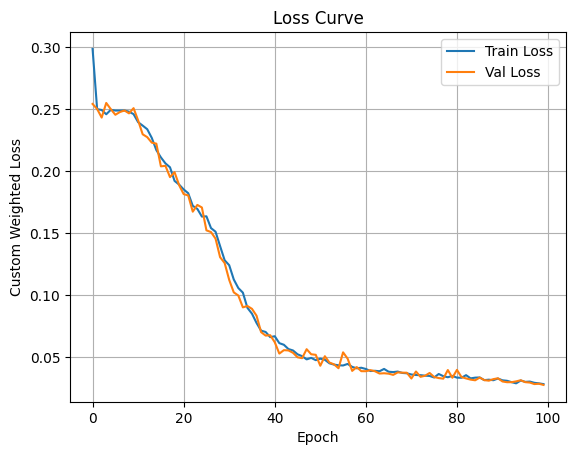

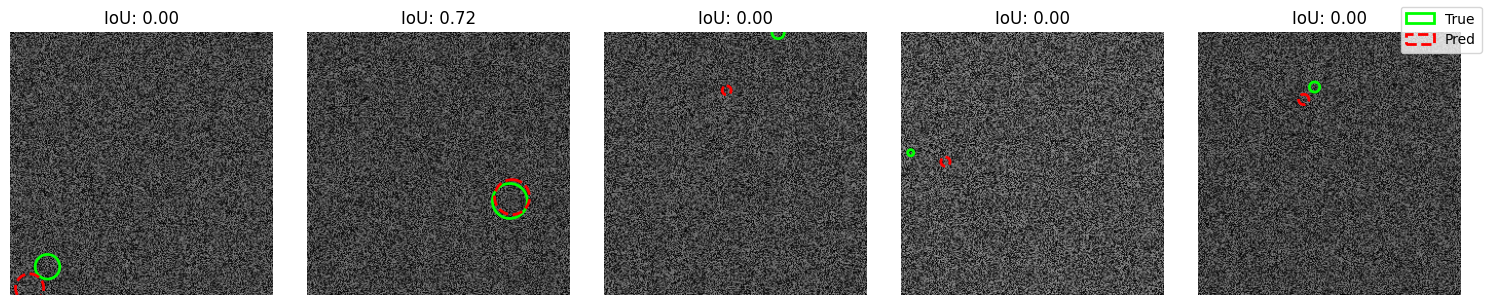

In [ ]:
# --------- Evaluation and Visualization ---------
def show_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, true = dataset[idx]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device)).cpu().numpy()[0]
        # Denormalize
        true_row = true[0].item() * IMG_SIZE
        true_col = true[1].item() * IMG_SIZE
        true_rad = true[2].item() * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN
        pred_row = pred[0] * IMG_SIZE
        pred_col = pred[1] * IMG_SIZE
        pred_rad = pred[2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].add_patch(plt.Circle((true_col, true_row), true_rad, color='lime', fill=False, linewidth=2, label='True'))
        axs[i].add_patch(plt.Circle((pred_col, pred_row), pred_rad, color='red', fill=False, linewidth=2, linestyle='--', label='Pred'))
        axs[i].set_title(f"IoU: {intersection_over_union({'row': true_row, 'col': true_col, 'radius': true_rad}, {'row': pred_row, 'col': pred_col, 'radius': pred_rad}):.2f}")
        axs[i].axis('off')
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

def intersection_over_union(circ1_dict, circ2_dict):
    shape1 = Point(circ1_dict['row'], circ1_dict['col']).buffer(circ1_dict['radius'])
    shape2 = Point(circ2_dict['row'], circ2_dict['col']).buffer(circ2_dict['radius'])
    return shape1.intersection(shape2).area / shape1.union(shape2).area

# --------- Example Usage ---------
if __name__ == '__main__':
    train_dataset = CircleOnTheFlyDataset(n_samples=8000)
    val_dataset = CircleOnTheFlyDataset(n_samples=2000)

    train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=100)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CircleFinderCNN()
    train_model(model, train_loader, val_loader, device, epochs=100, patience=15)

    show_predictions(model, val_dataset, device, num_samples=5)

In [ ]:
evaluate_model(model, val_loader, device)

IoU > 0.7 Accuracy: 44.20%


0.442

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import json
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from shapely.geometry import Point

# --------- Normalization Constants ---------
IMG_SIZE = 256
RADIUS_MIN, RADIUS_MAX = 3, 20

# --------- On-the-Fly Dataset Definition ---------
class CircleOnTheFlyDataset(Dataset):
    def __init__(self, n_samples=10000, noise_level=2):
        self.n_samples = n_samples
        self.noise_level = noise_level

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        img, label = generate_circle(noise_level=self.noise_level)
        img = np.expand_dims(img, axis=0)  # shape: (1, 256, 256)
        row = label['row'] / IMG_SIZE
        col = label['col'] / IMG_SIZE
        radius = (label['radius'] - RADIUS_MIN) / (RADIUS_MAX - RADIUS_MIN)
        target = torch.tensor([row, col, radius], dtype=torch.float32)
        return torch.tensor(img, dtype=torch.float32), target

# --------- CNN Model Definition ---------
class CircleFinderCNN(nn.Module):
    def __init__(self):
        super(CircleFinderCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 3)
        self.sigmoid = nn.Sigmoid()  # Output in range [0, 1]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# --------- Training Loop ---------
def train_model(model, train_loader, val_loader, device, epochs=100, lr=1e-4, patience=15):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def custom_loss(pred, target):
        pred_area = ((pred[:, 2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN) ** 2)
        true_area = ((target[:, 2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN) ** 2)
        area_loss = F.mse_loss(pred_area / 1000, true_area / 1000)  # scale area
        pos_loss = F.mse_loss(pred[:, 0:2], target[:, 0:2])
        return pos_loss + area_loss
    # def custom_loss(pred, target):
    #     pos_loss = F.mse_loss(pred[:, 0:2], target[:, 0:2])
    #     radius_loss = F.mse_loss(pred[:, 2], target[:, 2])  # normalized radius
    #     return pos_loss + 2 * radius_loss

    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = custom_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                loss = custom_loss(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Custom Weighted Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()




Epoch 1, Train Loss: 0.0979, Val Loss: 0.0950
Epoch 2, Train Loss: 0.0957, Val Loss: 0.0927
Epoch 3, Train Loss: 0.0942, Val Loss: 0.0968
Epoch 4, Train Loss: 0.0957, Val Loss: 0.0942
Epoch 5, Train Loss: 0.0948, Val Loss: 0.0942
Epoch 6, Train Loss: 0.0924, Val Loss: 0.0914
Epoch 7, Train Loss: 0.0915, Val Loss: 0.0891
Epoch 8, Train Loss: 0.0856, Val Loss: 0.0793
Epoch 9, Train Loss: 0.0758, Val Loss: 0.0694
Epoch 10, Train Loss: 0.0683, Val Loss: 0.0615
Epoch 11, Train Loss: 0.0576, Val Loss: 0.0568
Epoch 12, Train Loss: 0.0505, Val Loss: 0.0459
Epoch 13, Train Loss: 0.0442, Val Loss: 0.0418
Epoch 14, Train Loss: 0.0381, Val Loss: 0.0367
Epoch 15, Train Loss: 0.0346, Val Loss: 0.0314
Epoch 16, Train Loss: 0.0310, Val Loss: 0.0297
Epoch 17, Train Loss: 0.0290, Val Loss: 0.0288
Epoch 18, Train Loss: 0.0271, Val Loss: 0.0251
Epoch 19, Train Loss: 0.0258, Val Loss: 0.0235
Epoch 20, Train Loss: 0.0241, Val Loss: 0.0244
Epoch 21, Train Loss: 0.0230, Val Loss: 0.0234
Epoch 22, Train Loss: 

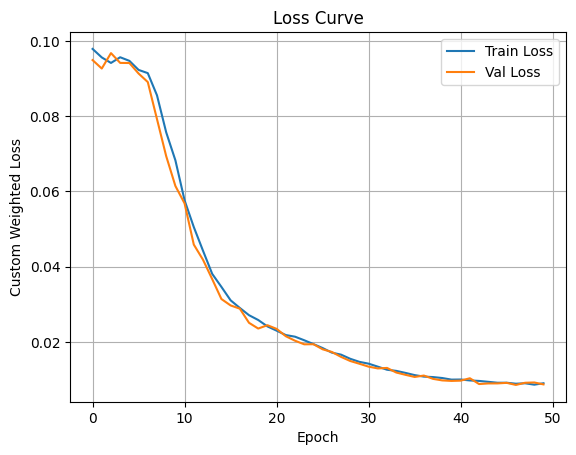

IoU > 0.7 Accuracy: 42.65%


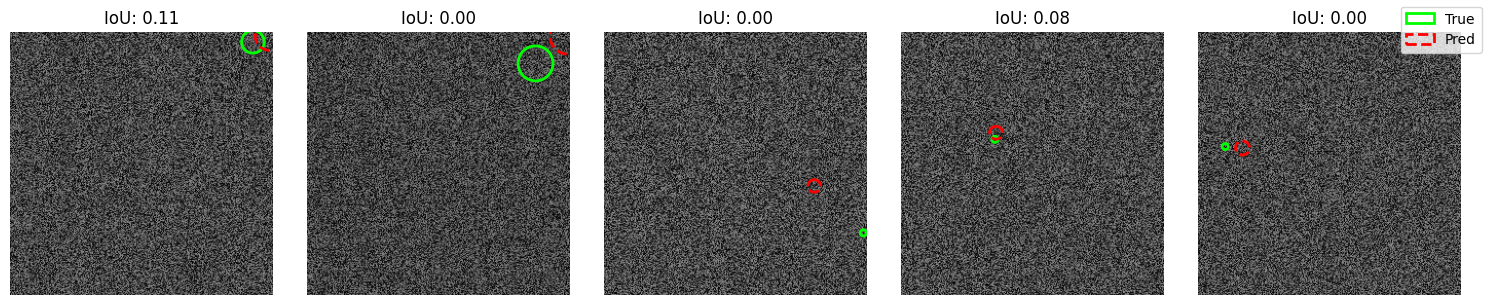

In [ ]:
# --------- Example Usage ---------
if __name__ == '__main__':
    train_dataset = CircleOnTheFlyDataset(n_samples=8000)
    val_dataset = CircleOnTheFlyDataset(n_samples=2000)

    train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=50)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CircleFinderCNN()
    train_model(model, train_loader, val_loader, device, epochs=50, patience=10)

    evaluate_model(model, val_loader, device)

    show_predictions(model, val_dataset, device, num_samples=5)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import json
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from shapely.geometry import Point
#from create_dataset import generate_circle

# --------- Normalization Constants ---------
IMG_SIZE = 256
RADIUS_MIN, RADIUS_MAX = 3, 20

# --------- On-the-Fly Dataset Definition ---------
class CircleOnTheFlyDataset(Dataset):
    def __init__(self, n_samples=10000, noise_level=2):
        self.n_samples = n_samples
        self.noise_level = noise_level

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        img, label = generate_circle(noise_level=self.noise_level)
        img = np.expand_dims(img, axis=0)
        row = label['row'] / IMG_SIZE
        col = label['col'] / IMG_SIZE
        radius = (label['radius'] - RADIUS_MIN) / (RADIUS_MAX - RADIUS_MIN)
        target = torch.tensor([row, col, radius], dtype=torch.float32)
        return torch.tensor(img, dtype=torch.float32), target

# --------- Fixed Validation Dataset from JSON ---------
class CircleJsonDataset(Dataset):
    def __init__(self, data_folder):
        self.files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.json')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], 'r') as f:
            data = json.load(f)
        img = np.array(data['img'], dtype=np.float32)
        label = data['label']
        img = np.expand_dims(img, axis=0)
        row = label['row'] / IMG_SIZE
        col = label['col'] / IMG_SIZE
        radius = (label['radius'] - RADIUS_MIN) / (RADIUS_MAX - RADIUS_MIN)
        target = torch.tensor([row, col, radius], dtype=torch.float32)
        return torch.tensor(img, dtype=torch.float32), target

# --------- CNN Model Definition ---------
def create_circular_kernel(kernel_size=5):
    center = (kernel_size - 1) / 2
    y, x = np.ogrid[:kernel_size, :kernel_size]
    dist = np.sqrt((x - center) ** 2 + (y - center) ** 2)
    circle = np.exp(-((dist - center) ** 2) / (2.0 * 0.5 ** 2))
    return torch.tensor(circle, dtype=torch.float32)

class CircleFinderCNN(nn.Module):
    def __init__(self):
        super(CircleFinderCNN, self).__init__()

        circular_kernel = create_circular_kernel(5).unsqueeze(0).unsqueeze(0)  # shape: (1, 1, 5, 5)
        self.fixed_conv = nn.Conv2d(1, 1, kernel_size=5, padding=2, bias=False)
        self.fixed_conv.weight = nn.Parameter(circular_kernel, requires_grad=False)

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.dropout = nn.Dropout(p=0.0)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fixed_conv(x)  # circular filter pre-processing
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 32 * 32)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        return x

# --------- Training Loop ---------
# (unchanged)




Epoch 1, Train Loss: 0.9405, Val Loss: 0.9324, IoU > 0.7 Accuracy: 0.00%
Epoch 2, Train Loss: 0.9406, Val Loss: 0.9324, IoU > 0.7 Accuracy: 0.00%
Epoch 3, Train Loss: 0.9284, Val Loss: 0.9324, IoU > 0.7 Accuracy: 0.00%
Epoch 4, Train Loss: 0.9400, Val Loss: 0.9324, IoU > 0.7 Accuracy: 0.00%
Epoch 5, Train Loss: 0.9507, Val Loss: 0.9324, IoU > 0.7 Accuracy: 0.00%
Epoch 6, Train Loss: 0.9372, Val Loss: 0.9324, IoU > 0.7 Accuracy: 0.00%
Epoch 7, Train Loss: 0.9352, Val Loss: 0.9324, IoU > 0.7 Accuracy: 0.00%
Epoch 8, Train Loss: 0.9303, Val Loss: 0.9324, IoU > 0.7 Accuracy: 0.00%
Epoch 9, Train Loss: 0.9365, Val Loss: 0.9324, IoU > 0.7 Accuracy: 0.00%
Epoch 10, Train Loss: 0.9357, Val Loss: 0.9324, IoU > 0.7 Accuracy: 0.00%
Epoch 11, Train Loss: 0.9457, Val Loss: 0.9324, IoU > 0.7 Accuracy: 0.00%
Epoch 12, Train Loss: 0.9424, Val Loss: 0.9324, IoU > 0.7 Accuracy: 0.00%
Epoch 13, Train Loss: 0.9304, Val Loss: 0.9324, IoU > 0.7 Accuracy: 0.00%
Epoch 14, Train Loss: 0.9424, Val Loss: 0.9324,

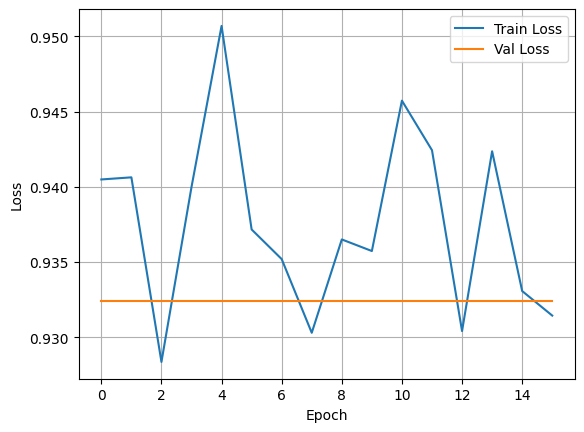

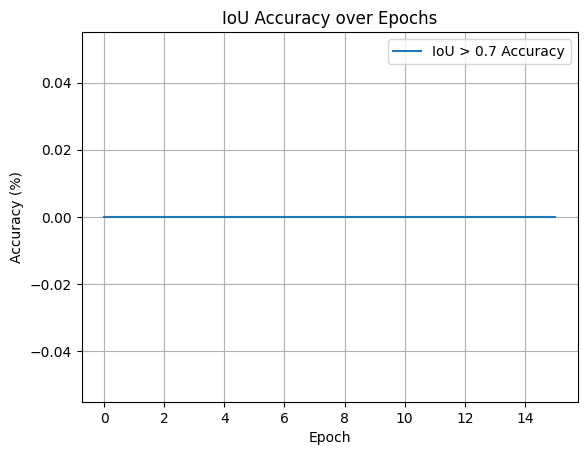

Model saved as 'circle_finder_model.pkl


ZeroDivisionError: float division by zero

In [ ]:
# --------- Example Usage ---------
if __name__ == '__main__':
    train_dataset = CircleOnTheFlyDataset(n_samples=8000)
    val_dataset = CircleJsonDataset('drive/MyDrive/data')

    #val_dataset = CircleOnTheFlyDataset(n_samples=2000)

    train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=100)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CircleFinderCNN()
    train_model(model, train_loader, val_loader, device, epochs=100, patience=15)

    evaluate_model(model, val_loader, device)

    show_predictions(model, val_dataset, device, num_samples=5)

In [9]:
for file in os.listdir("drive/MyDrive/data"):
    if file.endswith(".json"):
        with open(os.path.join("drive/MyDrive/data", file), "r") as f:
            try:
                d = json.load(f)
                if not (3 <= d['label']['radius'] <= 20):
                    print(f"Suspicious radius in: {file} → {d['label']['radius']}")
            except:
                continue



In [ ]:
# day2

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import json
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from shapely.geometry import Point
#from create_dataset import generate_circle

# --------- Normalization Constants ---------
IMG_SIZE = 256
RADIUS_MIN, RADIUS_MAX = 3, 20

In [11]:
def custom_loss(pred, target):
    return F.smooth_l1_loss(pred, target)  # also called Huber loss


In [12]:
def custom_loss(pred, target):
    return F.smooth_l1_loss(pred, target)  # also called Huber loss


In [30]:
# --------- CNN Model Definition ---------
# Make sure to call `model.to(device)` after initializing this model to match
# the device of your input tensors, especially when running on GPU in Colab.
class CircleFinderCNN(nn.Module):
    def __init__(self):
        super(CircleFinderCNN, self).__init__()

        # First convolutional block: extracts low-level features
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block: deeper pattern detection
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)

        # Third convolutional block: extracts high-level features
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Global Average Pooling layer: reduces each 32x32 feature map to a single value
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers for regression to (row, col, radius)
        self.fc1 = nn.Linear(64, 128)  # Reduced from 64*32*32 to just 64 using GAP
        self.fc2 = nn.Linear(128, 3)   # Outputs normalized values for [row, col, radius]
        self.sigmoid = nn.Sigmoid()   # Constrains output to [0, 1]

    def forward(self, x):
        # Ensure the input x is on the same device as the model
        # Useful check: assert x.device == next(self.parameters()).device
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.global_avg_pool(x)        # shape: (B, 64, 1, 1)
        x = x.view(x.size(0), -1)          # shape: (B, 64)
        x = F.relu(self.fc1(x))            # shape: (B, 128)
        x = self.sigmoid(self.fc2(x))      # shape: (B, 3) — normalized predictions
        return x

In [41]:
# --------- Normalization Constants ---------
IMG_SIZE = 256
RADIUS_MIN, RADIUS_MAX = 3, 20

# --------- On-the-Fly Dataset Definition ---------
class CircleOnTheFlyDataset(Dataset):
    def __init__(self, n_samples=10000, noise_level=2):
        self.n_samples = n_samples
        self.noise_level = noise_level

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        img, label = generate_circle(noise_level=self.noise_level)
        img = np.expand_dims(img, axis=0)  # shape: (1, 256, 256)
        row = label['row'] / IMG_SIZE
        col = label['col'] / IMG_SIZE
        radius = (label['radius'] - RADIUS_MIN) / (RADIUS_MAX - RADIUS_MIN)
        target = torch.tensor([row, col, radius], dtype=torch.float32)
        return torch.tensor(img, dtype=torch.float32), target

# --------- CNN Model Definition ---------
class CircleFinderCNN(nn.Module):
    def __init__(self):
        super(CircleFinderCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# --------- Load Train and Validation Dataset ---------
def load_dataloaders(batch_size=64, noise_level=2):
    full_dataset = CircleOnTheFlyDataset(n_samples=12000, noise_level=noise_level)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

# --------- Training Loop ---------
def train_model(model, train_loader, val_loader, device, epochs=100, lr=1e-4, patience=15):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def custom_loss(pred, target):
        return F.smooth_l1_loss(pred, target)  # also called Huber loss

    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = custom_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                loss = custom_loss(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Custom Weighted Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# --------- Example Usage ---------
if __name__ == '__main__':
    train_dataset = CircleOnTheFlyDataset(n_samples=8000)
    val_dataset = CircleJsonDataset('drive/MyDrive/data')

    #val_dataset = CircleOnTheFlyDataset(n_samples=2000)

    train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=100)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CircleFinderCNN()
    model.to(device) # Move the model to the device before training
    train_model(model, train_loader, val_loader, device, epochs=100, patience=15)

    evaluate_model(model, val_loader, device)

    show_predictions(model, val_dataset, device, num_samples=5)

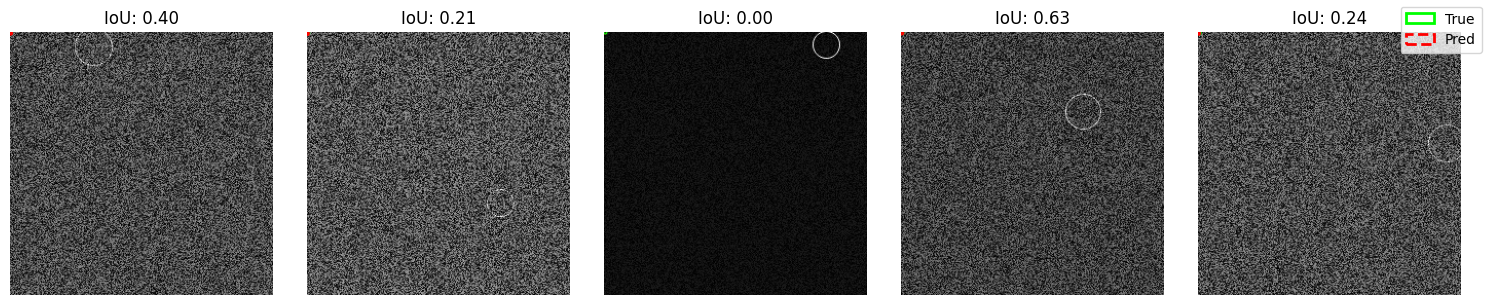

In [44]:
show_predictions(model, val_dataset, device, num_samples=5)

In [46]:
# --------- Normalization Constants ---------
IMG_SIZE = 256
RADIUS_MIN, RADIUS_MAX = 3, 20

# --------- On-the-Fly Dataset Definition ---------
class CircleOnTheFlyDataset(Dataset):
    def __init__(self, n_samples=10000, noise_level=2):
        self.n_samples = n_samples
        self.noise_level = noise_level

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        img, label = generate_circle(noise_level=self.noise_level)
        img = np.expand_dims(img, axis=0)  # shape: (1, 256, 256)
        row = label['row'] / IMG_SIZE
        col = label['col'] / IMG_SIZE
        radius = (label['radius'] - RADIUS_MIN) / (RADIUS_MAX - RADIUS_MIN)
        target = torch.tensor([row, col, radius], dtype=torch.float32)
        return torch.tensor(img, dtype=torch.float32), target

# --------- CNN Model Definition ---------
class CircleFinderCNN(nn.Module):
    def __init__(self):
        super(CircleFinderCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# --------- Load Train and Validation Dataset ---------
def load_dataloaders(batch_size=64, noise_level=2):
    train_dataset = CircleOnTheFlyDataset(n_samples=10000, noise_level=noise_level)
    val_dataset = CircleOnTheFlyDataset(n_samples=2000, noise_level=noise_level)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# --------- Evaluation ---------
def intersection_over_union(circ1_dict, circ2_dict):
    shape1 = Point(circ1_dict['row'], circ1_dict['col']).buffer(circ1_dict['radius'])
    shape2 = Point(circ2_dict['row'], circ2_dict['col']).buffer(circ2_dict['radius'])
    return shape1.intersection(shape2).area / shape1.union(shape2).area

def evaluate_model(model, dataloader, device, iou_threshold=0.7):
    model.eval()
    matches = 0
    total = 0
    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs).cpu().numpy()
            targets = targets.numpy()
            for pred, true in zip(outputs, targets):
                pred_dict = {
                    'row': pred[0] * IMG_SIZE,
                    'col': pred[1] * IMG_SIZE,
                    'radius': pred[2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN
                }
                true_dict = {
                    'row': true[0] * IMG_SIZE,
                    'col': true[1] * IMG_SIZE,
                    'radius': true[2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN
                }
                iou = intersection_over_union(pred_dict, true_dict)
                if iou > iou_threshold:
                    matches += 1
                total += 1
    accuracy = matches / total
    print(f"IoU > {iou_threshold} Accuracy: {accuracy:.2%}")
    return accuracy

# --------- Visualization ---------
def show_predictions(model, dataset, device, num_samples=5):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, true = dataset[idx]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device)).cpu().numpy()[0]
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].add_patch(plt.Circle(
            (true[1] * IMG_SIZE, true[0] * IMG_SIZE),  # (col, row)
            true[2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN,
            color='lime', fill=False, linewidth=2, label='True'))
        axs[i].add_patch(plt.Circle(
            (pred[1] * IMG_SIZE, pred[0] * IMG_SIZE),
            pred[2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN,
            color='red', fill=False, linewidth=2, linestyle='--', label='Pred'))
        iou = intersection_over_union(
            {'row': true[0] * IMG_SIZE, 'col': true[1] * IMG_SIZE, 'radius': true[2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN},
            {'row': pred[0] * IMG_SIZE, 'col': pred[1] * IMG_SIZE, 'radius': pred[2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN})
        axs[i].set_title(f"IoU: {iou:.2f}")
        axs[i].axis('off')
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

# --------- Training Loop ---------
def train_model(model, train_loader, val_loader, device, epochs=100, lr=1e-4, patience=15):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def custom_loss(pred, target):
        pred_area = ((pred[:, 2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN) ** 2)
        true_area = ((target[:, 2] * (RADIUS_MAX - RADIUS_MIN) + RADIUS_MIN) ** 2)
        area_loss = F.mse_loss(pred_area / 1000, true_area / 1000)  # scale area
        pos_loss = F.mse_loss(pred[:, 0:2], target[:, 0:2])
        return pos_loss + area_loss  # also called Huber loss

    model.to(device)
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for imgs, targets in train_loader:
            imgs, targets = imgs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = custom_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device)
                outputs = model(imgs)
                loss = custom_loss(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        evaluate_model(model, val_loader, device)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Custom Weighted Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
